#The Fluties - In The Money (ITM)

The Fluties pays out the top two spots. Let's investigate if we can predict how the top two spots will be.

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import stats

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE

full_scaled_teams = pd.read_csv("scaled_teams.csv")

In [2]:
def calc_itm_last(group):
    group.loc[group["rankCalculatedFinal"] < 3, 'itm'] = 1
    group.loc[group["rankCalculatedFinal"] >= 3, 'itm'] = 0
    group.loc[group["rankCalculatedFinal"] == 0, 'itm'] = np.nan
    group.loc[group["rankCalculatedFinal"] == group["rankCalculatedFinal"].max(), 'last_place'] = 1
    group.loc[group["last_place"] != 1, 'last_place'] = 0
    return group

itm_teams = full_scaled_teams.groupby("year").apply(calc_itm_last)
curr_teams = itm_teams.loc[itm_teams["year"] == 2020]
hist_teams = itm_teams.loc[itm_teams["year"] != 2020]

In [3]:
logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(hist_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "playoffSeed", "record.overall.wins"]], hist_teams["itm"])

In [4]:
rfe.ranking_

array([1, 1, 1, 1, 1])

In [5]:
sm_over = SMOTE(random_state=10)
sm_X, sm_y = sm_over.fit_resample(hist_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "playoffSeed", "record.overall.wins"]],  hist_teams["itm"])
logit = sm.Logit(sm_y, sm_X).fit()

Optimization terminated successfully.
         Current function value: 0.502879
         Iterations 6


In [6]:
logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.274     
Dependent Variable:  itm               AIC:               178.9675  
Date:                2020-12-11 16:43  BIC:               194.5873  
No. Observations:    168               Log-Likelihood:    -84.484   
Df Model:            4                 LL-Null:           -116.45   
Df Residuals:        163               LLR p-value:       4.3235e-13
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
scaled_pointsFor      0.1720   0.2138  0.8046 0.4210 -0.2470  0.5911
scaled_pointsAgainst  0.3810   0.2874  1.3257 0.1849 -0.1823  0.9444
scaled_moves          0.0705   0.2406  0.2929 0.7696 -0.4010  0.5420
playoffSeed          -0.3653   0.0734 -4.9749 0.0000 -0.5092 -0.2214
record.overall.wins   0.2599   0.0613  4.2392 0.0000  0.1398  0.3801
====================================================================

"""

In [7]:
log_pred = logit.predict(curr_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "playoffSeed", "record.overall.wins"]])

In [8]:
curr_teams["sm_pred"] = log_pred.values
curr_teams[["abbrev", "playoffSeed", "sm_pred"]]

,abbrev,playoffSeed,sm_pred
0,#1,1,0.921780
1,GUY,5,0.621785
2,Seth,4,0.492073
3,TMB,7,0.197152
4,Mill,10,0.067336
5,TWS,11,0.029611
6,BBc,3,0.819799
7,#50%,8,0.281647
8,faq,2,0.837500
9,JJJ,9,0.110330


In [9]:
oversample = SMOTE(random_state=10)
X, y = oversample.fit_resample(hist_teams[["scaled_pointsFor", "scaled_moves", "playoffSeed"]],  hist_teams["itm"])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [11]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


In [12]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[21  7]
 [ 5 18]]


In [13]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78        28
         1.0       0.72      0.78      0.75        23

    accuracy                           0.76        51
   macro avg       0.76      0.77      0.76        51
weighted avg       0.77      0.76      0.77        51



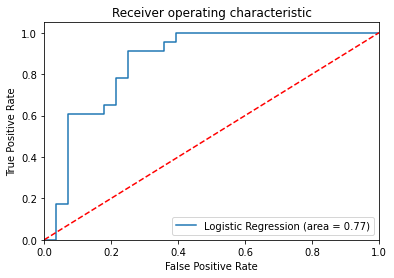

In [14]:

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [15]:
skl_pred = logreg.predict(curr_teams[["scaled_pointsFor", "scaled_moves", "playoffSeed"]])
curr_teams["skl_pred"] = skl_pred
curr_teams[["abbrev", "playoffSeed", "skl_pred"]]

,abbrev,playoffSeed,skl_pred
0,#1,1,1.0
1,GUY,5,0.0
2,Seth,4,1.0
3,TMB,7,0.0
4,Mill,10,0.0
5,TWS,11,0.0
6,BBc,3,1.0
7,#50%,8,0.0
8,faq,2,1.0
9,JJJ,9,0.0
